# Import

In [1]:
import sys
import os
import tqdm
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import torch
import fastai
import wfdb
import pickle

from models.fastai_model import fastai_model

# Utils

## Preprocessing

In [2]:
def load_raw_data_ptbxl(df, sampling_rate, path):
    if sampling_rate == 100:
        if os.path.exists(path + 'raw100.npy'):
            data = np.load(path+'raw100.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw100.npy', 'wb'), protocol=4)
    elif sampling_rate == 500:
        if os.path.exists(path + 'raw500.npy'):
            data = np.load(path+'raw500.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw500.npy', 'wb'), protocol=4)
    return data

In [3]:
def load_dataset(path, sampling_rate, release=False):

    if path.split('/')[-2] == 'ptbxl':
        # load and convert annotation data
        Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data_ptbxl(Y, sampling_rate, path)

    return X, Y

In [4]:
def compute_label_aggregations(df, folder, ctype):

    df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))

    aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)

    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:

        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]
        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))

    return df

In [5]:
def select_data(XX,YY, ctype, min_samples, outputfolder):
    # convert multilabel to multi-hot
    mlb = sklearn.preprocessing.MultiLabelBinarizer()

    if ctype == 'diagnostic':
        X = XX[YY.diagnostic_len > 0]
        Y = YY[YY.diagnostic_len > 0]
        mlb.fit(Y.diagnostic.values)
        y = mlb.transform(Y.diagnostic.values)
    elif ctype == 'subdiagnostic':
        counts = pd.Series(np.concatenate(YY.subdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.subdiagnostic = YY.subdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['subdiagnostic_len'] = YY.subdiagnostic.apply(lambda x: len(x))
        X = XX[YY.subdiagnostic_len > 0]
        Y = YY[YY.subdiagnostic_len > 0]
        mlb.fit(Y.subdiagnostic.values)
        y = mlb.transform(Y.subdiagnostic.values)
    elif ctype == 'superdiagnostic':
        counts = pd.Series(np.concatenate(YY.superdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.superdiagnostic = YY.superdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['superdiagnostic_len'] = YY.superdiagnostic.apply(lambda x: len(x))
        X = XX[YY.superdiagnostic_len > 0]
        Y = YY[YY.superdiagnostic_len > 0]
        mlb.fit(Y.superdiagnostic.values)
        y = mlb.transform(Y.superdiagnostic.values)
    elif ctype == 'form':
        # filter
        counts = pd.Series(np.concatenate(YY.form.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.form = YY.form.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['form_len'] = YY.form.apply(lambda x: len(x))
        # select
        X = XX[YY.form_len > 0]
        Y = YY[YY.form_len > 0]
        mlb.fit(Y.form.values)
        y = mlb.transform(Y.form.values)
    elif ctype == 'rhythm':
        # filter 
        counts = pd.Series(np.concatenate(YY.rhythm.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.rhythm = YY.rhythm.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['rhythm_len'] = YY.rhythm.apply(lambda x: len(x))
        # select
        X = XX[YY.rhythm_len > 0]
        Y = YY[YY.rhythm_len > 0]
        mlb.fit(Y.rhythm.values)
        y = mlb.transform(Y.rhythm.values)
    elif ctype == 'all':
        # filter 
        counts = pd.Series(np.concatenate(YY.all_scp.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.all_scp = YY.all_scp.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['all_scp_len'] = YY.all_scp.apply(lambda x: len(x))
        # select
        X = XX[YY.all_scp_len > 0]
        Y = YY[YY.all_scp_len > 0]
        mlb.fit(Y.all_scp.values)
        y = mlb.transform(Y.all_scp.values)
    else:
        pass

    # save LabelBinarizer
    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)

    return X, Y, y, mlb

In [6]:
def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

## Evaluation

In [7]:
def apply_thresholds(preds, thresholds):
	"""
		apply class-wise thresholds to prediction score in order to get binary format.
		BUT: if no score is above threshold, pick maximum. This is needed due to metric issues.
	"""
	tmp = []
	for p in preds:
		tmp_p = (p > thresholds).astype(int)
		if np.sum(tmp_p) == 0:
			tmp_p[np.argmax(p)] = 1
		tmp.append(tmp_p)
	tmp = np.array(tmp)
	return tmp

In [8]:
def challenge_metrics(y_true, y_pred, beta1=2, beta2=2, class_weights=None, single=False):
    f_beta = 0
    g_beta = 0
    if single: # if evaluating single class in case of threshold-optimization
        sample_weights = np.ones(y_true.sum(axis=1).shape)
    else:
        sample_weights = y_true.sum(axis=1)
    for classi in range(y_true.shape[1]):
        y_truei, y_predi = y_true[:,classi], y_pred[:,classi]
        TP, FP, TN, FN = 0.,0.,0.,0.
        for i in range(len(y_predi)):
            sample_weight = sample_weights[i]
            if y_truei[i]==y_predi[i]==1: 
                TP += 1./sample_weight
            if ((y_predi[i]==1) and (y_truei[i]!=y_predi[i])): 
                FP += 1./sample_weight
            if y_truei[i]==y_predi[i]==0: 
                TN += 1./sample_weight
            if ((y_predi[i]==0) and (y_truei[i]!=y_predi[i])): 
                FN += 1./sample_weight 
        f_beta_i = ((1+beta1**2)*TP)/((1+beta1**2)*TP + FP + (beta1**2)*FN)
        g_beta_i = (TP)/(TP+FP+beta2*FN)

        f_beta += f_beta_i
        g_beta += g_beta_i

    return {'F_beta_macro':f_beta/y_true.shape[1], 'G_beta_macro':g_beta/y_true.shape[1]}

In [9]:
def evaluate_experiment(y_true, y_pred, thresholds=None):
    results = {}

    if not thresholds is None:
        # binary predictions
        y_pred_binary = apply_thresholds(y_pred, thresholds)
        # PhysioNet/CinC Challenges metrics
        challenge_scores = challenge_metrics(y_true, y_pred_binary, beta1=2, beta2=2)
        results['F_beta_macro'] = challenge_scores['F_beta_macro']
        results['G_beta_macro'] = challenge_scores['G_beta_macro']

    # label based metric
    results['macro_auc'] = roc_auc_score(y_true, y_pred, average='macro')
    
    df_result = pd.DataFrame(results, index=[0])
    return df_result

# Load your data

Before finetuning a pretrained model of the experiments we provide in our repository (or precomputed and provided [here](https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq)), first load your custom 100 Hz sampled 12-lead ECG signal data `X` of shape `[N,L,12]` in Millivolts (mV) and multi-hot encoded labels `y` of shape `[N,C]` as numpy arrays, where `C` is the number of classes and `N` the number of total samples in this dataset. Although PTB-XL comes with fixed `L=1000` (i,e. 10 seconds), it is not required to be fixed, **BUT** the shortest sample must be longer than `input_size` of the specific model (e.g. 2.5 seconds for our fastai-models).

For proper tinetuning split your data into four numpy arrays: `X_train`,`y_train`,`X_val` and `y_val`

### Example: finetune model trained on all (71) on superdiagnostic (5)
Below we provide an example for loading [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/) aggregated at the `superdiagnostic` level, where we use the provided folds for train-validation-split:

In [10]:
#from utils import utils

sampling_frequency=100
datafolder='C:/Users/AliceKitchkin/Repos/CNN_LSTM_x_ECG/data/ptbxl/'
task='subdiagnostic'
outputfolder='../output/'

# Load PTB-XL data
data, raw_labels = load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
data, labels, Y, mlb = select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)


# --- Classes ---
class_names = list(mlb.classes_)
num_classes = len(class_names)
print(f"Alle verfügbaren Klassen: {class_names}")
print(f"Anzahl Klassen: {num_classes}")

classes_to_pred = ['AMI', 'IMI', 'NORM']
klassen_indizes = [i for i, name in enumerate(class_names) if name in classes_to_pred]

Y_filtered = Y[:, klassen_indizes]
class_names_filtered = [class_names[i] for i in klassen_indizes]

class_names = class_names_filtered  # <=== number of classes in the finetuning dataset
num_classes = len(class_names)
# ----------------


# 1-9 for training 
X_train = data[labels.strat_fold < 10]
#y_train = Y[labels.strat_fold < 10] # old
y_train = Y_filtered[labels.strat_fold < 10]

# 10 for validation
X_val = data[labels.strat_fold == 10]
#y_val = Y[labels.strat_fold == 10] # old
y_val = Y_filtered[labels.strat_fold == 10]


input_shape = [1000,12]             # <=== shape of samples, [None, 12] in case of different lengths

X_train.shape, y_train.shape, X_val.shape, y_val.shape


print(f"Gefiltert auf {len(class_names)} Klassen: {class_names}")

Alle verfügbaren Klassen: ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
Anzahl Klassen: 23
Gefiltert auf 3 Klassen: ['AMI', 'IMI', 'NORM']


In [11]:
print("Label-Verteilung nach Filterung:")
for i, class_name in enumerate(class_names):
    positive_samples = (y_train[:, i] == 1).sum()
    total_samples = len(y_train)
    print(f"{class_name}: {positive_samples}/{total_samples} ({positive_samples/total_samples*100:.1f}%)")

print(f"\nSamples ohne jedes Label: {(y_train.sum(axis=1) == 0).sum()}")

Label-Verteilung nach Filterung:
AMI: 2772/19230 (14.4%)
IMI: 2944/19230 (15.3%)
NORM: 8551/19230 (44.5%)

Samples ohne jedes Label: 5863


# Train or download models
There are two possibilities:
   1. Run the experiments as described in README. Afterwards you find trained in models in `output/expX/models/`
   2. Download the precomputed `output`-folder with all experiments and models from [here]((https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq))

# Load pretrained model

For loading a pretrained model:
   1. specify `modelname` which can be seen in `code/configs/` (e.g. `modelname='fastai_xresnet1d101'`)
   2. provide `experiment` to build the path `pretrainedfolder` (here: `exp0` refers to the experiment with `all` 71 SCP-statements)
   
This returns the pretrained model where the classification is replaced by a random initialized head with the same number of outputs as the number of classes.

In [12]:
experiment = 'exp0'
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output/'+experiment+'/models/'+modelname+'/'
mpath='../output/' # <=== path where the finetuned model will be stored
n_classes_pretrained = 71 # <=== because we load the model from exp0, this should be fixed because this depends the experiment

model = fastai_model(
    modelname, 
    num_classes, 
    sampling_frequency, 
    mpath, 
    input_shape=input_shape, 
    pretrainedfolder=pretrainedfolder,
    n_classes_pretrained=n_classes_pretrained, 
    pretrained=True,
    epochs_finetuning=2,
)

# Preprocess data with pretrained Standardizer

Since we standardize inputs to zero mean and unit variance, your custom data needs to be standardized with the respective mean and variance. This is also provided in the respective experiment folder `output/expX/data/standard_scaler.pkl`

In [13]:
standard_scaler = pickle.load(open('../output/'+experiment+'/data/standard_scaler.pkl', "rb"))

X_train = apply_standardizer(X_train, standard_scaler)
X_val = apply_standardizer(X_val, standard_scaler)

# Finetune model

Calling `model.fit` of a model with `pretrained=True` will perform finetuning as proposed in our work i.e. **gradual unfreezing and discriminative learning rates**. 

In [14]:
model.fit(X_train, y_train, X_val, y_val)

Finetuning...
model: fastai_xresnet1d101


c:\Users\AliceKitchkin\miniconda3\envs\ecg_benchmarking_env\Lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sou

epoch,train_loss,valid_loss,time


c:\Users\AliceKitchkin\miniconda3\envs\ecg_benchmarking_env\Lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sou

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.225781,0.239176,03:03
1,0.188895,0.223474,03:17


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.181140,0.220914,03:51
1,0.184937,0.219745,04:20


# Evaluate model on validation data

In [15]:
y_val_pred = model.predict(X_val)
evaluate_experiment(y_val, y_val_pred)

model: fastai_xresnet1d101


aggregating predictions...


,macro_auc
0,0.956714


## Plots

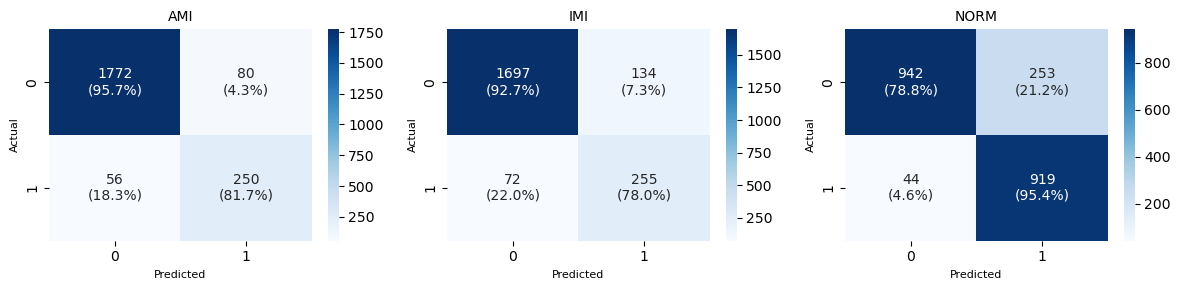

In [21]:
%matplotlib inline

y_val_binary = (y_val > 0.5).astype(int)
y_pred_binary = (y_val_pred > 0.5).astype(int)

# Dynamische Berechnung der Grid-Größe
import math
cols = min(6, num_classes)  # Maximal 6 Spalten
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))

# Flatten axes array für einfacheren Zugriff
if num_classes == 1:
    axes = [axes]
elif rows == 1:
    axes = axes
else:
    axes = axes.flatten()

for i in range(num_classes):
    cm = confusion_matrix(y_val_binary[:, i], y_pred_binary[:, i])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Kombiniere absolute Zahlen und Prozentzahlen
    labels = np.asarray([f'{v1}\n({v2:.1f}%)' 
                        for v1, v2 in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{class_names[i]}', fontsize=10)
    axes[i].set_xlabel('Predicted', fontsize=8)
    axes[i].set_ylabel('Actual', fontsize=8)

# Verstecke leere Subplots
for j in range(num_classes, rows * cols):
    if j < len(axes):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

^^^
This plot displays binary confusion matrices for each of the 5 superdiagnostic classes (NORM, MI, STTC, CD, HYP). Each heatmap shows true positives, true negatives, false positives, and false negatives for individual classes, helping to identify which classes the model confuses most often.

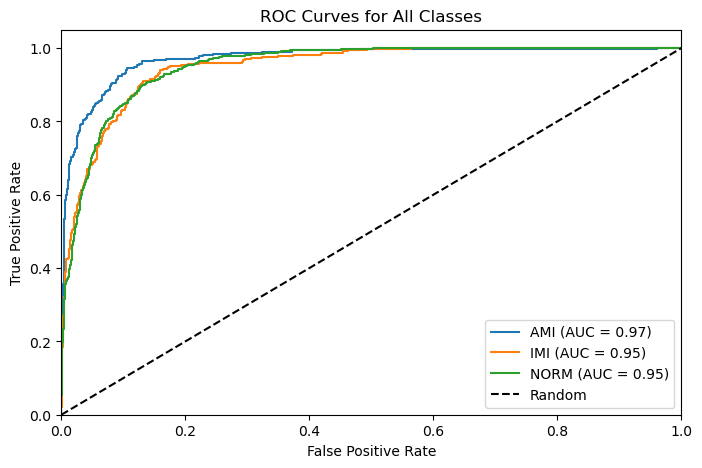

In [20]:
%matplotlib inline

plt.figure(figsize=(8, 5))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.show()

^^^This plot shows Receiver Operating Characteristic (ROC) curves for all 5 classes on a single graph. Each curve displays the trade-off between true positive rate and false positive rate at various threshold settings. The Area Under Curve (AUC) values indicate model performance, with values closer to 1.0 being better.

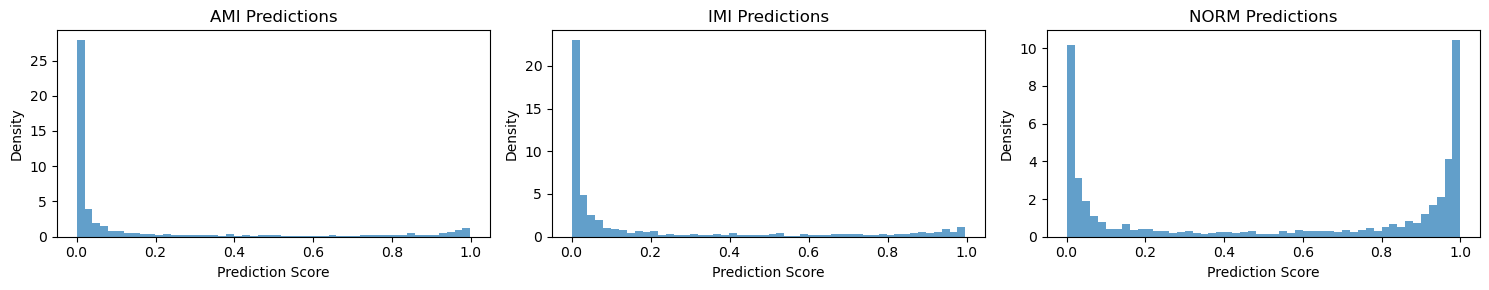

In [18]:
%matplotlib inline
plt.figure(figsize=(15, 3))

for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    plt.hist(y_val_pred[:, i], bins=50, alpha=0.7, density=True)
    plt.title(f'{class_names[i]} Predictions')
    plt.xlabel('Prediction Score')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

^^^This plot shows histograms of prediction probability distributions for each class. It visualizes how confident the model is in its predictions - well-separated distributions (peaks near 0 and 1) indicate the model makes confident decisions, while distributions concentrated around 0.5 suggest uncertainty.